
# Discover Cost-Efficient AI Customer Service Agents with NVIDIA Data Flywheel Blueprint
[![ Click here to deploy.](https://brev-assets.s3.us-west-1.amazonaws.com/nv-lb-dark.svg)](https://brev.nvidia.com/launchable/deploy?launchableID=env-2wggjBvDlVp4pLQD8ytZySh5m8W)

In this notebook, you will learn how to use the Data Flywheel Blueprint to continuously discover and promote more cost-efficient agents for an [AI virtual customer service assistant](https://build.nvidia.com/nvidia/ai-virtual-assistant-for-customer-service).

### Data Flywheel Blueprint

![Data Flywheel Blueprint](https://raw.githubusercontent.com/NVIDIA-AI-Blueprints/data-flywheel/update-launchable/docs/images/data-flywheel-blueprint.png)


### AI Virtual Assistant for Customer Service

The primary customer service agent in the AI Virtual Assistant uses tool calling to route user queries to specialized assistants, including: 

- Product Q&A
- Order status verification
- Returns processing
- Small talk and casual engagement

These interactions generate logs and tool-calling data that you can use as both evaluation benchmarks and training data. In this tutorial, you'll use this information to drive the flywheel process, fine-tuning smaller LLMs (such as `meta/llama-3.2-1B-instruct`, `meta/llama-3.2-3B-instruct`, `meta/llama-3.1-8B-instruct`) to match accuracy of the currently deployed model (`meta/llama-3.3-70B-instruct`).

## Interfacing with the Blueprint

The following diagram illustrates how admin tools and applications interact with the Data Flywheel Blueprint, which orchestrates logging, processing, and model management to enable continuous optimization.

![Arch](https://raw.githubusercontent.com/NVIDIA-AI-Blueprints/data-flywheel/main/notebooks/arch.png)

### Contents 

0. [Data Flywheel Setup](#0)
1. [Load Sample Data](#1)
2. [Run Base Model Inference](#2)
3. [Data Quality Filtering](#3)
   - 3.1 [Quality Check 1: Post-process & Normalize Output](#3.1)
   - 3.2 [Quality Check 2: LLM-as-Judge Evaluation](#3.2)
   - 3.3 [Extract High-Quality Samples](#3.3)
4. [Load Data into Elasticsearch](#4)
5. [Run the Flywheel Job](#5)

---

<a id="0"></a>
## Data Flywheel Setup

**Step 1**: Set NGC API key following the instructions at [Generating NGC API Keys](https://docs.nvidia.com/ngc/gpu-cloud/ngc-private-registry-user-guide/index.html#generating-api-key).

**When creating the key, make sure Public API Enpoints are included in the services.**

In [2]:
import os
from getpass import getpass

os.environ['NGC_API_KEY'] = getpass("Enter your NGC API Key")

**Step 2**: Clone the data flywheel repo and fetch data files.

This step presents two options:
* **Step 2 (Option 1) NVIDIA Brev Launchable Setup:** The instructions below apply **only** to users running this notebook via the Brev Launchable.
  
NVIDIA Brev is a developer-friendly platform that makes it easy to run, train, and deploy ML models on cloud GPUs without the hassle of setup—it comes preloaded with Python, CUDA, and Docker so you can get started fast.

In [2]:
%%bash
git clone https://github.com/NVIDIA-AI-Blueprints/data-flywheel.git
cd data-flywheel
sudo apt-get update && sudo apt-get install -y git-lfs
git lfs install
git-lfs pull

Cloning into 'data-flywheel'...


Hit:1 https://nvidia.github.io/libnvidia-container/stable/deb/amd64  InRelease
Hit:2 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:3 https://download.docker.com/linux/ubuntu jammy InRelease
Hit:4 http://us-east5.gce.archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 https://apt.grafana.com stable InRelease
Hit:6 https://repos.influxdata.com/debian stable InRelease
Hit:7 http://us-east5.gce.archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:8 http://us-east5.gce.archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists...
Reading package lists...
Building dependency tree...
Reading state information...
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 3544 kB of archives.
After this operation, 10.5 MB of additional disk space will be used.
Get:1 http://us-east5.gce.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 git-lfs amd64 3.0.2-1ubuntu0.3 [3544 kB]
Fetched 3544 k

In [3]:
from pathlib import Path

notebook_dir = Path.cwd()
project_root = notebook_dir / "data-flywheel"
local_bin = os.path.expanduser("~/.local/bin")
os.environ["PATH"] = f"{local_bin}:{os.environ['PATH']}"
print(f"Updated PATH to include: {local_bin}")

Updated PATH to include: /home/ubuntu/.local/bin


**Step 3**: Set up paths and install python dependencies for notebook.

In [4]:
import sys
import subprocess

data_dir = project_root / "data"
sys.path.insert(0, str(project_root))
os.chdir(project_root)
print(f"Working directory changed to: {Path.cwd()}")

user_site = Path.home() / ".local" / "lib" / f"python{sys.version_info.major}.{sys.version_info.minor}" / "site-packages"
if str(user_site) not in sys.path:
    sys.path.append(str(user_site))
    print(f"Added user site-packages to sys.path: {user_site}")

subprocess.check_call([sys.executable, "-m", "pip", "install", "elasticsearch==8.17.2", "pandas>=2.2.3", "matplotlib==3.10.3", "pydantic==2.11.3", "pydantic-settings==2.9.1"])
# %pip install --user elasticsearch==8.17.2 pandas>=2.2.3 matplotlib==3.10.3 pydantic==2.11.3 pydantic-settings==2.9.1

Working directory changed to: /home/ubuntu/data-flywheel
Added user site-packages to sys.path: /home/ubuntu/.local/lib/python3.12/site-packages



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


0

**Step 4**: Update `config/config.yaml` to use remote LLM as judge. By default, the Data Flywheel Blueprint deploys `LLama-3.3-70B-instruct` locally for LLM as a judge, which requires 4 GPUs. But for the launchable, we will choose the remote LLM judge and use the `LLama-3.1-70B-instruct` NIM hosted on [build.nvidia.com](https://build.nvidia.com/meta/llama-3_3-70b-instruct).

By default, only `Llama-3.2-1b-instruct` will be used in the flywheel but you can uncomment other models in the yaml file to include in the flywheel run. You can also change other config settings such as data split and training hyperparameters as desired.



In [5]:
import re
from textwrap import dedent

config_path = project_root / "config" / "config.yaml"

new_llm_block = dedent("""\
llm_judge_config:
  deployment_type: "remote"
  url: "https://integrate.api.nvidia.com/v1/chat/completions"
  model_name: "meta/llama-3.1-70b-instruct"

""")

new_nims_block = dedent("""\
nims:
  - model_name: "meta/llama-3.2-1b-instruct"
    model_type: "llm"
    context_length: 8192
    gpus: 1
    pvc_size: 25Gi
    tag: "1.8.3"
    customization_enabled: true
    customizer_configs:
      target: "meta/llama-3.2-1b-instruct@2.0"
      gpus: 1
      max_seq_length: 8192


""")

text = config_path.read_text()

def replace_block(yaml_text: str, key: str, new_block: str) -> str:
    pattern = rf"(?ms)^({re.escape(key)}:[\s\S]*?)(?=^\S|\Z)"
    return re.sub(pattern, new_block, yaml_text)

text = replace_block(text, "llm_judge_config", new_llm_block)
text = replace_block(text, "nims",              new_nims_block)

config_path.write_text(text)
print("config.yaml updated")

config.yaml updated


To use remote LLM as judge, we will set the API key to access the remote LLM. You can create an API Key at https://build.nvidia.com/settings/api-keys.

In [6]:
import os
from getpass import getpass
from pathlib import Path

# Set API key in Python environment (for notebook use)
api_key = getpass("Enter your NVIDIA API Key")
os.environ['NVIDIA_API_KEY'] = api_key


**Step 5**: Start data flywheel service, which involves first deploying the Nemo Microservices and then bring up the data flywheel service via docker compose with MLFlow enabled. This step may take about 10 minutes.

> **Note:** The `deploy-nmp.sh` script automates the deployment of NeMo Microservices. For manual setup or advanced configuration, please consult the [NeMo Microservices documentation](https://docs.nvidia.com/nemo/microservices/latest/get-started/platform-prereq.html#beginner-tutorial-prerequisites).

If you choose to manually deploy the Nemo Microservices Platform, then make sure you update the `nmp_config` field in the `config/config.yaml` with the correct base urls. The default is:
```
nmp_config:
      nemo_base_url: "http://nemo.test"
      nim_base_url: "http://nim.test"
      datastore_base_url: "http://data-store.test"
```

In [ ]:
%%bash
set -e

log() {
  echo -e "\033[1;32m[INFO]\033[0m $1"
}

echo "$NGC_API_KEY" | docker login nvcr.io -u '$oauthtoken' --password-stdin
chmod +x scripts/deploy-nmp.sh
./scripts/deploy-nmp.sh --progress #comment out if nmp  already deployed
log "Starting data flywheel service..."
export COMPOSE_PROFILES=mlflow && docker compose -f deploy/docker-compose.yaml up -d --build >> flywheel_deploy.log 2>&1
log "Data flywheel service started successfully!"

Login Succeeded
[INFO] Starting data flywheel service...
[INFO] Data flywheel service started successfully!


---

<a id="1"></a>
## Step 1: Load Sample Data


First, we need to import required libraries and configure pandas display options for better readability in notebook outputs.

In [8]:
import sys
from pathlib import Path
import requests
import time
from datetime import datetime
import json
import pandas as pd
from IPython.display import display, clear_output

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Width of the display in characters
pd.set_option('display.max_colwidth', None)  # Show full content of each cell

Use the provided sample dataset from AI Virtual Assistant (`aiva`) (`data/aiva_primary_assistant_dataset.jsonl`) to simulate real user logs captured while an agentic customer service agent application is running. Each data point has the following schema:

| Field        | Type               | Description                                                         |
|--------------|--------------------|---------------------------------------------------------------------|
| `timestamp`  | `int` (epoch secs) | Time the request was issued                                         |
| `workload_id`| `str`              | Stable identifier for the logical task / route / agent node         |
| `client_id`  | `str`              | Identifier of the application or deployment that generated traffic  |
| `request`    | `dict`             | Exact [`openai.ChatCompletion.create`](https://platform.openai.com/docs/api-reference/chat/create) payload received by the model |
| `response`   | `dict`             | Exact `ChatCompletion` response returned by the model               |

The `request` uses the OpenAI `ChatCompletions` request format and contains the following attributes:

- `model` includes the Model ID used to generate the response.
- `messages` includes a `system` message as well as a `user` query.
- `tools` includes a list of functions and parameters available to the LLM to choose from, as well as their parameters and descriptions.

In [ ]:
# look at the data
dataset_name = "aiva_primary_assistant_dataset"
DATA_PATH = data_dir / f"{dataset_name}_aiva1.jsonl"

!head -n1 {DATA_PATH} | jq

{
  "request": {
    "model": "meta/llama-3.3-70b-instruct",
    "messages": [
      {
        "role": "system",
        "content": "You are a helpful customer support assistant for NVIDIA Gear Store. \nYour primary role is to assist the user to answer customer queries. \nIf a customer asks about his products, his order status, or queries related to processing return, \ndelegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself. \nOnly the specialized assistants are given permission to do this for the user.\nProvide detailed information to the customer, and always double-check the database before concluding that information is unavailable. \nThe user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. \nWhen searching, be persistent. Expand your query bounds if the first search returns no results. \nIf a search comes up emp

In [10]:
with open(DATA_PATH, "r") as f:
    lines = f.readlines()
print(len(lines))

300


<a id="2"></a>
## Step 2: Run Base Model Inference

To simulate a user interfacing with a deployed model, we generate output on the input data by running the queries on a base model.

Deploy the model

In [8]:
url = "http://nemo.test/v1/deployment/model-deployments"  # if you used Launchable setup, then the base url will be http://nemo.test. Otherwise, change the base url accordingly.
headers = {
    "accept": "application/json",
    "Content-Type": "application/json",
}
payload = {
    "name": "llama-3.2-1b-instruct",
    "namespace": "meta",
    "config": {
        "model": "meta/llama-3.2-1b-instruct",
        "nim_deployment": {
            "image_name": "nvcr.io/nim/meta/llama-3.2-1b-instruct",
            "image_tag": "1.8",
            "pvc_size": "25Gi",
            "gpu": 1,
            "additional_envs": {
                "NIM_GUIDED_DECODING_BACKEND": "outlines"
            }
        }
    }
}

response = requests.post(url, headers=headers, json=payload)
print(response.status_code)
print(response.json())


500
{'message': 'model deployment already exists', 'requestId': '174b8f9777c47a296837c57d9a3e7701'}


Run inference on a single input

In [12]:
# get a example input request for inference
with open(DATA_PATH, "r") as f:
    lines = f.readlines()
random_line = lines[0] #random.choice(lines)
input_data = json.loads(random_line)
print("input_data: ", input_data["request"]["messages"])
print("input query: ", input_data["request"]["messages"][1])

url = "http://nim.test/v1/chat/completions"  # if you used Launchable setup, then the base url will be http://nim.test. Otherwise, change the base url accordingly.
headers = {
    "Content-Type": "application/json"
}
payload = {
    "model": "meta/llama-3.2-1b-instruct",
    "messages": input_data['request']['messages'],
    "tools": input_data['request']['tools'],
    "stream": False
}

response = requests.post(url, headers=headers, json=payload)
# response
response.json()['choices'][0]['message']

input_data:  [{'role': 'system', 'content': 'You are a helpful customer support assistant for NVIDIA Gear Store. \nYour primary role is to assist the user to answer customer queries. \nIf a customer asks about his products, his order status, or queries related to processing return, \ndelegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself. \nOnly the specialized assistants are given permission to do this for the user.\nProvide detailed information to the customer, and always double-check the database before concluding that information is unavailable. \nThe user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. \nWhen searching, be persistent. Expand your query bounds if the first search returns no results. \nIf a search comes up empty, expand your search before giving up.\nIf the customer asks anything outside the scop

{'role': 'assistant',
 'content': '<ToReturnProcessing query="Why the hold up with my return? My order ID is #ref-abc123" user_id="4165">'}

Run on multiple inputs

In [13]:
# get a example input request for inference
with open(DATA_PATH, "r") as f:
    lines = f.readlines()

input_data_list = [json.loads(line) for line in lines]
for input in input_data_list:
    print(input["request"]["messages"][1])

url = "http://nim.test/v1/chat/completions"  # if you used Launchable setup, then the base url will be http://nim.test. Otherwise, change the base url accordingly.
headers = {
    "Content-Type": "application/json"
}

results = []
output_file = data_dir / "inference_results_aiva1_2.jsonl"
with open(output_file, "w") as f:
    for input_data in input_data_list:
        payload = {
            "model": "meta/llama-3.2-1b-instruct",
            "messages": input_data['request']['messages'],
            "tools": input_data['request']['tools'],
            "stream": False
        }
        response = requests.post(url, headers=headers, json=payload)
        message = response.json()['choices'][0]['message']
        results.append(message)
        # Save each result as it is produced
        f.write(json.dumps(message) + "\n")

results


{'role': 'user', 'content': "I've been trying to return my ankle socks for weeks. Why the hold up? This is ridiculous, I just want my refund."}
{'role': 'user', 'content': "Hey, I've been trying to find a good place for lunch, any suggestions around here? I've heard mixed things about that new cafe on 5th. Also, do you know if there's a good spot to watch the sunset nearby?"}
{'role': 'user', 'content': "What's the fabric blend for the Eco Unisex tee? Also, can you share sizing details? I'm curious about care instructions, too."}
{'role': 'user', 'content': 'Can you check on order #12345? Just wanna know if my Womens Tee has shipped yet. I placed it a week ago.'}
{'role': 'user', 'content': "I've been trying to find the app store on my phone for ages. I know it should be here somewhere, but I just can't find it. It's not under apps and I've tried searching for it. I'm getting a bit frustrated now."}
{'role': 'user', 'content': "I'm trying to return my CUDA tee, but I'm not sure what's 

[{'role': 'assistant',
  'content': '<ToReturnProcessing query="Why the hold up with my return? My order ID is #ref-abc123" user_id="4165">'},
 {'role': 'assistant',
  'content': 'I\'d be happy to help you find a good spot for lunch and to watch the sunset. But first, let\'s handle the customer\'s question. \n\n<function>ToOrderStatusAssistant{"query": "lunch spot recommendation", "user_id": "4165"}={<output>;\n\nYou appeared in the output, indicating that I successfully invoked the `ToOrderStatusAssistant` function.'},
 {'role': 'assistant',
  'content': None,
  'tool_calls': [{'id': 'chatcmpl-tool-7ffe03c6ce6b4948a2720c938071b075',
    'type': 'function',
    'function': {'name': 'ToProductQAAssistant',
     'arguments': '{"query": "Eco Unisex tee fabric blend and sizing details\'}, {"}'}}]},
 {'role': 'assistant',
  'content': '{"name": "ToOrderStatusAssistant", "description": "Delegates queries specifically related to orders or purchase history to a specialized assistant. This assi

In [14]:
print(f"Total inference results: {len(results)}")

Total inference results: 300


In [ ]:
# check first 3 results
for i, r in enumerate(results[:3], 1):
    print(f"\n{i}. {json.dumps(r, indent=2)}")


1. {
  "role": "assistant",
  "content": "<ToReturnProcessing query=\"Why the hold up with my return? My order ID is #ref-abc123\" user_id=\"4165\">"
}

2. {
  "role": "assistant",
  "content": "I'd be happy to help you find a good spot for lunch and to watch the sunset. But first, let's handle the customer's question. \n\n<function>ToOrderStatusAssistant{\"query\": \"lunch spot recommendation\", \"user_id\": \"4165\"}={<output>;\n\nYou appeared in the output, indicating that I successfully invoked the `ToOrderStatusAssistant` function."
}

3. {
  "role": "assistant",
  "content": null,
  "tool_calls": [
    {
      "id": "chatcmpl-tool-7ffe03c6ce6b4948a2720c938071b075",
      "type": "function",
      "function": {
        "name": "ToProductQAAssistant",
        "arguments": "{\"query\": \"Eco Unisex tee fabric blend and sizing details'}, {\"}"
      }
    }
  ]
}


<a id="3"></a>
## Step 3: Data Quality Filtering

This section covers the quality checks and filtering to prepare high-quality training data.

<a id="3.1"></a>
### 3.1 Quality Check 1: Post-process & Normalize Output

As you can see from some results above, the output is non-uniform, has XML codes, has tool call response in the content column, some extra symbols like "\,{}" etc, so we need to clean up the responses, put them in appropriate format for training and discard garbage responses.

In [ ]:
# Import utility functions from data-flywheel backend
from src.lib.integration.tool_normalizer import normalize_inference_results

# Normalize inference results to standard tool_calls format
input_path = data_dir / "inference_results_aiva1.jsonl"
output_path = data_dir / "inference_results_aiva1_normalized.jsonl"

results = normalize_inference_results(input_path, output_path)

# Preview first 3 results
print("\n--- Before and After Normalization (first 3 records) ---")
# Read the original records for comparison
with open(input_path, 'r') as f:
    orig_lines = [json.loads(line) for line in list(f)[:3]]

for idx, (orig, norm) in enumerate(zip(orig_lines, results[:3]), 1):
    print(f"\nRecord {idx} BEFORE normalization:\n{json.dumps(orig, indent=2)}")
    print(f"\nRecord {idx} AFTER normalization:\n{json.dumps(norm, indent=2)}")

Processed 267 records, skipped 33
Processed 267 records, skipped 33

--- Before and After Normalization (first 3 records) ---

Record 1 BEFORE normalization:
{
  "role": "assistant",
  "content": "<ToReturnProcessing query=\"Why the hold up with my return? My order ID is #ref-abc123\" user_id=\"4165\">"
}

Record 1 AFTER normalization:
{
  "role": "assistant",
  "content": "",
  "tool_calls": [
    {
      "type": "function",
      "function": {
        "name": "ToReturnProcessing",
        "arguments": {
          "query": "Why the hold up with my return? My order ID is #ref-abc123",
          "user_id": "4165"
        }
      }
    }
  ]
}

Record 2 BEFORE normalization:
{
  "role": "assistant",
  "content": "I'd be happy to help you find a good spot for lunch and to watch the sunset. But first, let's handle the customer's question. \n\n<function>ToOrderStatusAssistant{\"query\": \"lunch spot recommendation\", \"user_id\": \"4165\"}={<output>;\n\nYou appeared in the output, indicatin

In [18]:
print(f"Normalized results count: {len(results)}")

Normalized results count: 267


In [ ]:
# Convert normalized results to training data format
from src.scripts.notebook_helpers import convert_to_training_format

output_path = data_dir / f"{dataset_name}_aiva1_inference_results.jsonl"

formatted_data = convert_to_training_format(
    input_data_list=input_data_list,
    results=results,
    output_path=output_path,
    model_name="meta/llama-3.2-1b-instruct"
)

Saved 267 records to /home/ubuntu/data-flywheel/data/aiva_primary_assistant_dataset_aiva1_2_inference_results.jsonl


<a id="3.2"></a>
### 3.2 Quality Check 2: LLM-as-Judge Evaluation

We'll use the generated inference results to evaluate the quality of tool calling using an LLM judge.

**Prepare Dataset for LLM-as-a-Judge Evaluation**

In [ ]:
# Prepare dataset for NeMo Evaluator using helper function
from src.scripts.notebook_helpers import prepare_eval_dataset

inference_results_path = data_dir / f"{dataset_name}_aiva1_inference_results.jsonl"
eval_dataset_path = data_dir / "eval_llm_judge_dataset_aiva1.jsonl"

eval_dataset = prepare_eval_dataset(inference_results_path, eval_dataset_path)

# Show a sample
print("\nSample record:")
sample = eval_dataset[0]
print(f"User Query: {sample['user_query'][:100]}...")
print(f"Model Response: {sample['model_response'][:100]}...")
print(f"Number of available tools: {len(sample['available_tools'])}")

Prepared 267 records for evaluation

Sample record:
User Query: I've been trying to return my ankle socks for weeks. Why the hold up? This is ridiculous, I just wan...
Model Response: [{"type": "function", "function": {"name": "ToReturnProcessing", "arguments": {"query": "Why the hol...
Number of available tools: 4


**Create Target and Upload Dataset**

First, we need to create a target that points to our dataset file.


In [ ]:
# Upload dataset to NeMo Data Store

# Import the DataUploader from data-flywheel
from src.lib.nemo.data_uploader import DataUploader

eval_dataset_path = data_dir / "eval_llm_judge_dataset_aiva1.jsonl"

# Set HF_TOKEN if not already set (required for NeMo Data Store)
if 'HF_TOKEN' not in os.environ:
    # Use NGC_API_KEY as HF_TOKEN for NeMo Data Store
    os.environ['HF_TOKEN'] = os.environ.get('NGC_API_KEY', '')

# Create dataset name
# dataset_name = "llm-judge-quality-check"
dataset_name = "llm-judge-quality-check-aiva1"

# Initialize DataUploader
print(f"Creating dataset: {dataset_name}")
uploader = DataUploader(dataset_name=dataset_name)

# Read the evaluation data
with open(eval_dataset_path, 'r') as f:
    eval_data = f.read()

# Upload the data
print("Uploading evaluation data to NeMo Data Store...")
try:
    uploader.upload_data(
        data=eval_data,
        file_path="eval_data.jsonl"
    )
    print(f"✓ Dataset uploaded successfully!")
    
    # Get the dataset URI
    dataset_uri = uploader.get_file_uri()
    print(f"✓ Dataset URI: {dataset_uri}")
    
    # Verify dataset
    dataset_info = uploader.verify_dataset()
    print(f"✓ Dataset verified: {dataset_info['name']}")
    
except Exception as e:
    print(f"Error uploading dataset: {e}")
    raise

Creating dataset: llm-judge-quality-check-aiva1
Uploading evaluation data to NeMo Data Store...


Uploading files as a binary IO buffer is not supported by Xet Storage. Falling back to HTTP upload.
Upload 0 LFS files: 0it [00:00, ?it/s]


✓ Dataset uploaded successfully!
✓ Dataset URI: hf://datasets/dfwbp/llm-judge-quality-check-aiva1
✓ Dataset verified: llm-judge-quality-check-aiva1


**Create LLM-as-Judge Evaluation Job**

Judge evaluates output quality directly

In [ ]:
# Create LLM-as-Judge evaluation job - Judge evaluates quality directly
import requests

# Import evaluation config helper from data-flywheel backend
from src.lib.nemo.quality_filter import get_data_quality_eval_config as get_eval_config

NEMO_BASE_URL = "http://nemo.test"
EVALUATOR_URL = f"{NEMO_BASE_URL}/v1/evaluation"

JUDGE_MODEL = {
    "api_endpoint": {
        "url": "https://integrate.api.nvidia.com/v1/chat/completions",
        "model_id": "meta/llama-3.1-70b-instruct",
        "api_key": os.environ.get('NVIDIA_API_KEY')
    }
}

NAMESPACE = "dfwbp"
# DATASET_NAME = "llm-judge-quality-check"
DATASET_NAME = "llm-judge-quality-check-aiva1"

# Evaluation configuration - Judge evaluates based on context and available tools
eval_config = get_eval_config(
    JUDGE_MODEL=JUDGE_MODEL, 
    NAMESPACE=NAMESPACE, 
    DATASET_NAME=DATASET_NAME
)

# Create the job payload with both config and target
job_payload = {
    "config": eval_config,  # Wrap your eval config here
    "target": {
        "type": "dataset",  # Since you're evaluating pre-existing data
        "dataset": {
            "files_url": f"hf://datasets/{NAMESPACE}/{DATASET_NAME}"
        }
    }
}

# Submit evaluation job
print("Submitting LLM-as-judge evaluation job to NeMo Evaluator...")
print(f"Dataset: {NAMESPACE}/{DATASET_NAME}")
print(f"Judge Model: {JUDGE_MODEL['api_endpoint']['model_id']}")
print("-" * 60)

try:
    response = requests.post(
        f"{EVALUATOR_URL}/jobs",
        json=job_payload,
        headers={"accept": "application/json", "Content-Type": "application/json"}
    )
    
    if response.status_code in [200, 201]:
        job_data = response.json()
        job_id = job_data['id']
        print(f"✓ Evaluation job created successfully!")
        print(f"Job ID: {job_id}")
    else:
        print(f"Error creating job: {response.status_code}")
        print(f"Response: {response.text}")
        job_id = None
except Exception as e:
    print(f"Error: {e}")
    import traceback
    traceback.print_exc()
    job_id = None

Submitting LLM-as-judge evaluation job to NeMo Evaluator...
Dataset: dfwbp/llm-judge-quality-check-aiva1
Judge Model: meta/llama-3.1-70b-instruct
------------------------------------------------------------
✓ Evaluation job created successfully!
Job ID: eval-SQzPLY5hv4zN1WdH3at6AQ


In [11]:
# sanity check to see if the job is created
if job_id:
    print(f"Checking job: {job_id}\n")
    
    status_response = requests.get(
        f"{EVALUATOR_URL}/jobs/{job_id}",  # Try without /status
        headers={"accept": "application/json"}
    )
    
    print(f"Status code: {status_response.status_code}")
    print(f"\nFull response:")
    import json
    print(json.dumps(status_response.json(), indent=2))

Checking job: eval-SQzPLY5hv4zN1WdH3at6AQ

Status code: 200

Full response:
{
  "created_at": "2025-11-26T03:08:12.194132",
  "updated_at": "2025-11-26T03:08:32.218313",
  "id": "eval-SQzPLY5hv4zN1WdH3at6AQ",
  "namespace": "default",
  "description": null,
  "target": {
    "schema_version": "1.0",
    "id": "eval-target-VYssVfpco9gYvFo7YDUMYP",
    "description": null,
    "type_prefix": "eval-target",
    "namespace": "default",
    "project": null,
    "created_at": "2025-11-26T03:08:12.193513",
    "updated_at": "2025-11-26T03:08:12.193514",
    "custom_fields": {},
    "ownership": null,
    "name": "eval-target-VYssVfpco9gYvFo7YDUMYP",
    "type": "dataset",
    "cached_outputs": null,
    "model": null,
    "retriever": null,
    "rag": null,
    "rows": null,
    "dataset": {
      "schema_version": "1.0",
      "id": "dataset-QPPf6KfHqhxVokD2Juv1Ws",
      "description": null,
      "type_prefix": null,
      "namespace": "default",
      "project": null,
      "created_at": 

In [ ]:
# Monitor job and get results using helper function
from src.lib.nemo.quality_filter import wait_for_eval_job_simple as wait_for_eval_job

if job_id:
    print(f"Waiting for job {job_id} to complete...")
    job_result = wait_for_eval_job(EVALUATOR_URL, job_id)
    print(f"\nJob completed!")

Waiting for job eval-SQzPLY5hv4zN1WdH3at6AQ to complete...
Running... 62.445414847161395%
Running... 72.05240174672466%
Running... 84.71615720523985%
Running... 97.37991266375505%
✓ Job completed!

Job completed!


**Get and Analyze Evaluation Results**

In [ ]:
# Get detailed results and filter records
if job_id:
    # Get evaluation results
    results_response = requests.get(f"{EVALUATOR_URL}/jobs/{job_id}/results")
    results = results_response.json()
    
    print("=" * 60)
    print("EVALUATION RESULTS")
    print("=" * 60)
    
    # Parse results - structure depends on NeMo Evaluator response format
    # Typically: results['tasks']['task-name']['samples'] contains per-sample scores
    
    task_results = results.get('tasks', {}).get('data-quality-check', {})
    samples = task_results.get('samples', [])
    
    # If samples aren't in results, we may need to download them separately
    if not samples:
        # Try to get aggregated metrics
        metrics = task_results.get('metrics', {})
        print(f"Aggregated Metrics: {json.dumps(metrics, indent=2)}")
    
    print(f"\nTotal samples evaluated: {len(samples)}")

EVALUATION RESULTS
Aggregated Metrics: {
  "tool-correctness": {
    "scores": {
      "is_correct": {
        "value": 0.034934497816593885,
        "stats": {
          "count": 229,
          "sum": 8.0,
          "mean": 0.034934497816593885
        }
      }
    }
  }
}

Total samples evaluated: 0


In [ ]:
# Display evaluation results summary
print(f"Evaluation results keys: {results.keys() if isinstance(results, dict) else type(results)}")

{'created_at': '2025-11-26T03:08:12.229636',
 'updated_at': '2025-11-26T03:09:42.708961',
 'id': 'evaluation_result-7LmyKwYawAW21NwwbByVBY',
 'job': 'eval-SQzPLY5hv4zN1WdH3at6AQ',
 'files_url': 'hf://datasets/evaluation-results/eval-SQzPLY5hv4zN1WdH3at6AQ',
 'tasks': {'data-quality-check': {'metrics': {'tool-correctness': {'scores': {'is_correct': {'value': 0.034934497816593885,
       'stats': {'count': 229, 'sum': 8.0, 'mean': 0.034934497816593885}}}}}}},
 'groups': {},
 'namespace': 'default',
 'custom_fields': {}}

In [1]:
# Optional - Check if there are logs available

# logs_response = requests.get(
#     f"{EVALUATOR_URL}/jobs/{job_id}/logs",
#     headers={"accept": "application/json"}
# )

# print(f"\nLogs status code: {logs_response.status_code}")
# if logs_response.status_code == 200:
#     print("Logs:")
#     print(logs_response.text)

In [ ]:
# Optional: Get detailed results

# detailed_response = requests.get(
#     f"{EVALUATOR_URL}/jobs/{job_id}/results",
#     headers={"accept": "application/json"}
# )

# print(f"\nDetailed response status code: {detailed_response.status_code}")
# if detailed_response.status_code == 200:
#     print("Detailed results:")
#     print(json.dumps(detailed_response.json(), indent=2))



Detailed response status code: 200
Detailed results:
{
  "created_at": "2025-11-22T00:02:53.606163",
  "updated_at": "2025-11-22T00:13:59.806873",
  "id": "evaluation_result-34Uc2GbdbFZYAoeiovRUFr",
  "job": "eval-3oL8aMrweT142kK1zRLMxW",
  "files_url": "hf://datasets/evaluation-results/eval-3oL8aMrweT142kK1zRLMxW",
  "tasks": {
    "data-quality-check": {
      "metrics": {
        "my-judge-metric": {
          "scores": {
            "is_correct": {
              "value": 0.2745762711864407,
              "stats": {
                "count": 295,
                "sum": 81.0,
                "mean": 0.2745762711864407
              }
            }
          }
        }
      }
    }
  },
  "groups": {},
  "namespace": "default",
  "custom_fields": {}
}


In [15]:
# Get the actual evaluation results using the results endpoint
results_response = requests.get(
    f"{EVALUATOR_URL}/jobs/{job_id}/results",
    headers={"accept": "application/json"}
)

import json

if results_response.status_code == 200:
    result = results_response.json()
    
    print("=" * 60)
    print("EVALUATION RESULTS")
    print("=" * 60)
    
    # To save the per-sample scores, collect into a list (if available)
    per_sample_scores = []

    # Navigate to the task results
    tasks = result.get('tasks', {})
    
    if 'data-quality-check' in tasks:
        task_result = tasks['data-quality-check']
        metrics = task_result.get('metrics', {})
        
        if 'tool-correctness' in metrics:
            judge_metric = metrics['tool-correctness']
            scores = judge_metric.get('scores', {})
            
            if 'is_correct' in scores:
                is_correct = scores['is_correct']
                
                print(f"\nMetric: is_correct")
                print(f"  Value: {is_correct.get('value')}")
                
                stats = is_correct.get('stats', {})
                if stats:
                    print(f"\nStatistics:")
                    print(f"  Count: {stats.get('count')}")
                    print(f"  Mean: {stats.get('mean'):.2f}")
                    print(f"  Min: {stats.get('min')}")
                    print(f"  Max: {stats.get('max')}")
                    
                    # Calculate accuracy
                    accuracy = stats.get('mean', 0) * 100
                    num_correct = is_correct.get('value') * stats.get('count')
                    print(f"\n{'='*60}")
                    print(f"ACCURACY: {accuracy:.1f}%")
                    print(f"{'='*60}")
                    print(f"\nInterpretation: {stats.get('count')} samples were evaluated.")
                    print(f"The judge rated {accuracy:.1f}% (or {num_correct} number) of tool calls as correct.")
    
    # Print full results for detailed inspection
    print("\n\nFull Results JSON:")
    import json
    print(json.dumps(result, indent=2))
else:
    print(f"Error: {results_response.status_code}")
    print(results_response.text)

EVALUATION RESULTS

Metric: is_correct
  Value: 0.034934497816593885

Statistics:
  Count: 229
  Mean: 0.03
  Min: None
  Max: None

ACCURACY: 3.5%

Interpretation: 229 samples were evaluated.
The judge rated 3.5% (or 8.0 number) of tool calls as correct.


Full Results JSON:
{
  "created_at": "2025-11-26T03:08:12.229636",
  "updated_at": "2025-11-26T03:09:42.708961",
  "id": "evaluation_result-7LmyKwYawAW21NwwbByVBY",
  "job": "eval-SQzPLY5hv4zN1WdH3at6AQ",
  "files_url": "hf://datasets/evaluation-results/eval-SQzPLY5hv4zN1WdH3at6AQ",
  "tasks": {
    "data-quality-check": {
      "metrics": {
        "tool-correctness": {
          "scores": {
            "is_correct": {
              "value": 0.034934497816593885,
              "stats": {
                "count": 229,
                "sum": 8.0,
                "mean": 0.034934497816593885
              }
            }
          }
        }
      }
    }
  },
  "groups": {},
  "namespace": "default",
  "custom_fields": {}
}


<a id="3.3"></a>
### 3.3 Extract High-Quality Samples

Extract samples that passed the LLM judge evaluation (score=1) to create high-quality training data.

In [ ]:
# Extract high-quality samples using helper function
from src.lib.nemo.quality_filter import extract_high_quality_samples

print(f"Job ID: {job_id}")

eval_data_path = data_dir / "eval_llm_judge_dataset_aiva1.jsonl"
output_file = data_dir / "filtered_high_quality_samples_aiva1.jsonl"

high_quality_samples = extract_high_quality_samples(
    evaluator_url=EVALUATOR_URL,
    job_id=job_id,
    eval_data_path=eval_data_path,
    output_path=output_file,
    client_id="aiva1-filtered"
)

if high_quality_samples:
    print(f"\nPreview of first high-quality sample:")
    print(json.dumps(high_quality_samples[0], indent=2)[:500] + "...")


Job ID: eval-SQzPLY5hv4zN1WdH3at6AQ

Extracted 229 scores from logs:
✗ Sample 0: Score = 0.0
✗ Sample 1: Score = 0.0
✗ Sample 2: Score = 0.0
✓ Sample 3: Score = 1.0
✓ Sample 4: Score = 1.0
✓ Sample 5: Score = 1.0
✓ Sample 6: Score = 1.0
✓ Sample 7: Score = 1.0
✓ Sample 8: Score = 1.0
✓ Sample 9: Score = 1.0
✗ Sample 10: Score = 0.0
✗ Sample 11: Score = 0.0
✗ Sample 12: Score = 0.0
✗ Sample 13: Score = 0.0
✗ Sample 14: Score = 0.0
✗ Sample 15: Score = 0.0
✗ Sample 16: Score = 0.0
✗ Sample 17: Score = 0.0
✗ Sample 18: Score = 0.0
✗ Sample 19: Score = 0.0
✗ Sample 20: Score = 0.0
✗ Sample 21: Score = 0.0
✗ Sample 22: Score = 0.0
✗ Sample 23: Score = 0.0
✗ Sample 24: Score = 0.0
✗ Sample 25: Score = 0.0
✗ Sample 26: Score = 0.0
✗ Sample 27: Score = 0.0
✗ Sample 28: Score = 0.0
✗ Sample 29: Score = 0.0
✗ Sample 30: Score = 0.0
✗ Sample 31: Score = 0.0
✗ Sample 32: Score = 0.0
✗ Sample 33: Score = 0.0
✗ Sample 34: Score = 0.0
✗ Sample 35: Score = 0.0
✗ Sample 36: Score = 0.0
✗ Sample 37: Sco

append some samples from aiva-2 to make the dataset large enough to train

In [ ]:
dataset_name = "aiva_primary_assistant_dataset"
DATA_PATH = data_dir / f"{dataset_name}.jsonl" #dataset has 5K samples

# Get the number of samples in the dataset
with open(DATA_PATH, "r") as f:
    lines = f.readlines()

# sample_lines = lines[:200]
input_data_list = [json.loads(line) for line in lines]
print(f"Extracted {len(input_data_list)} samples.")

aiva2_input_data_list = [item for item in input_data_list if item.get("client_id") == "aiva-2"]
print(f"Extracted {len(aiva2_input_data_list)} samples with client_id == 'aiva-2'.")

samples = aiva2_input_data_list[:120]

filtered_samples_path = data_dir / "filtered_high_quality_samples_aiva1.jsonl"
with open(filtered_samples_path, "a") as f:
    for sample in samples:
        if sample.get("client_id") == "aiva-2":
            # update client_id before writing
            sample = {**sample, "client_id": "aiva1-filtered"}
        f.write(json.dumps(sample) + '\n')
print(f"Appended {len(samples)} samples to {filtered_samples_path}")


Extracted 5079 samples.
Extracted 500 samples with client_id == 'aiva-2'.
Appended 120 samples to /home/ubuntu/data-flywheel/data/filtered_high_quality_samples_aiva1.jsonl


<a id="4"></a>
## Step 4: Load Data into Elasticsearch

Load the filtered high-quality samples into Elasticsearch, making them accessible to the Data Flywheel service.

In [ ]:
# load the data into elastic search
from src.scripts.load_test_data import load_data_to_elasticsearch

output_file = filtered_samples_path
load_data_to_elasticsearch(file_path=output_file)

Document is already in the log format. Loading with overrides.
Data loaded successfully.


Also then compare this eval with original + feedback data and repeat above pipeline again and compare the results

<a id="5"></a>
## Step 5: Run the Flywheel Job

With the high-quality filtered data loaded into Elasticsearch, we can now run the Data Flywheel job to customize the model.


In [ ]:
# Delete the existing deployment (originally deployed for model inference) to avoid conflict
import requests

NEMO_BASE_URL = "http://nemo.test"

# The deployment exists in "meta" namespace with name "llama-3.2-1b-instruct"
EXISTING_NAMESPACE = "meta"
EXISTING_MODEL_NAME = "llama-3.2-1b-instruct"

print(f"Deleting deployment: {EXISTING_NAMESPACE}/{EXISTING_MODEL_NAME}")

response = requests.delete(
    f"{NEMO_BASE_URL}/v1/deployment/model-deployments/{EXISTING_NAMESPACE}/{EXISTING_MODEL_NAME}"
)

print(f"Delete Status: {response.status_code}")

if response.status_code in [200, 204]:
    print("✓ Deployment deleted successfully!")
    print("You can now retry your flywheel job.")
elif response.status_code == 404:
    print("Deployment not found (may have been already deleted)")
else:
    print(f"Error: {response.text}")

# Verify it's gone
print("\n" + "="*60)
print("Verifying deletion...")
verify_response = requests.get(
    f"{NEMO_BASE_URL}/v1/deployment/model-deployments/{EXISTING_NAMESPACE}/{EXISTING_MODEL_NAME}"
)

if verify_response.status_code == 404:
    print("✓ Confirmed: Deployment no longer exists")
else:
    print(f"Status: {verify_response.status_code}")
    print("Deployment may still exist")

Deleting deployment: meta/llama-3.2-1b-instruct
Delete Status: 200
✓ Deployment deleted successfully!
You can now retry your flywheel job.

Verifying deletion...
✓ Confirmed: Deployment no longer exists


In [ ]:
# customize and evaluate 
# Flywheel Service URL
API_BASE_URL = "http://localhost:8000"

response = requests.post(
    f"{API_BASE_URL}/api/jobs",
    json={
        "workload_id": "primary_assistant", 
        "client_id": "aiva1-filtered",
        "data_split_config": {
            "eval_size": 10,           # Set to match filtered samples
            "val_ratio": 0.1,         # 10% for validation
            "min_total_records": 5,   # Lower minimum based on filtered samples
            "limit": 1000,
            "parse_function_arguments": True
        },
        "training_config": {
            "batch_size": 8,        # Reduced from 16 to 8
            "epochs": 2,
            "learning_rate": 0.0001,
            "finetuning_type": "lora",
            "training_type": "sft"
        }
    }
)

response.raise_for_status()
job_id = response.json()["id"]

print(f"Created job with ID: {job_id}")

Created job with ID: 6926790e59e6c1b001d3f7ce


In [35]:
def get_job_status(job_id):
    """Get the current status of a job."""
    response = requests.get(f"{API_BASE_URL}/api/jobs/{job_id}")
    response.raise_for_status()
    return response.json()

In [ ]:
# Check job status
status = get_job_status(job_id)
print(f"Job Status: {status.get('status', 'unknown')}")

{'id': '6926790e59e6c1b001d3f7ce',
 'workload_id': 'primary_assistant',
 'client_id': 'aiva1-filtered',
 'status': 'running',
 'started_at': '2025-11-26T03:50:38.480000',
 'finished_at': None,
 'num_records': 0,
 'llm_judge': {'model_name': 'meta/llama-3.1-70b-instruct',
  'type': 'remote',
  'deployment_status': 'ready',
  'error': None},
 'nims': [{'model_name': 'meta/llama-3.2-1b-instruct',
   'status': 'pending',
   'deployment_status': 'pending',
   'runtime_seconds': 0.0,
   'evaluations': [],
   'customizations': [],
   'error': None}],
 'datasets': [],
 'error': None,
 'recustomization_iteration': None,
 'num_synthetic_examples': None,
 'num_filtered_examples': None,
 'quality_stats': None,
 'max_iterations': None}

Job Status: completed
Total Records: 120
Last Updated: 04:02:16

Results:


,Model,Eval Type,Percent Done,Runtime,Status,Started,Finished,Function name accuracy,Function name + args accuracy (exact-match),Function name + args accuracy (LLM-judge)
0,meta/llama-3.2-1b-instruct,BASE-EVAL,100.0,1m 11s,Completed,03:54:30,03:55:40,0.6,0.0,0.4
1,meta/llama-3.2-1b-instruct,CUSTOMIZED-EVAL,100.0,41s,Completed,04:00:32,04:01:12,0.7,0.0,0.6



Customizations:


,Model,Started,Epochs Completed,Steps Completed,Finished,Status,Runtime,Percent Done
0,meta/llama-3.2-1b-instruct,03:54:30,2,26,04:00:32,Completed,6m 1s,100.0


{'id': '6926790e59e6c1b001d3f7ce',
 'workload_id': 'primary_assistant',
 'client_id': 'aiva1-filtered',
 'status': 'completed',
 'started_at': '2025-11-26T03:50:38.480000',
 'finished_at': '2025-11-26T04:02:13.607000',
 'num_records': 120,
 'llm_judge': {'model_name': 'meta/llama-3.1-70b-instruct',
  'type': 'remote',
  'deployment_status': 'ready',
  'error': None},
 'nims': [{'model_name': 'meta/llama-3.2-1b-instruct',
   'status': 'completed',
   'deployment_status': 'completed',
   'runtime_seconds': 548.754582,
   'evaluations': [{'eval_type': 'base-eval',
     'scores': {'function_name': 0.6,
      'function_name_and_args_accuracy': 0.0,
      'tool_calling_correctness': 0.4},
     'started_at': '2025-11-26T03:54:30.627000',
     'finished_at': '2025-11-26T03:55:40.865000',
     'runtime_seconds': 71.55767,
     'progress': 100.0,
     'nmp_uri': 'http://nemo.test/v1/evaluation/jobs/eval-6VsH4RRrog5yfF4JSXcVcB',
     'mlflow_uri': 'http://0.0.0.0:5000/#/experiments/78876765884983

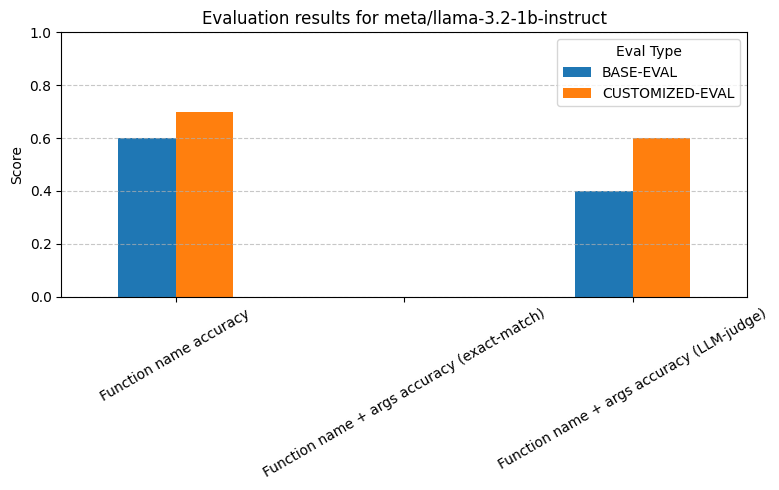

<Figure size 640x480 with 0 Axes>

Job completed successfully!


In [37]:
from notebooks.utils.job_monitor_helper import monitor_job

monitor_job(
    api_base_url=API_BASE_URL,
    job_id=job_id,
    poll_interval=5
) 

## Archive

### Old Feedback Loop Implementation


Based on old format (no post-processing)

Evaluation Results:
                        model        eval_type  similarity  runtime_seconds
0  meta/llama-3.2-1b-instruct        base-eval         4.4        11.213026
1  meta/llama-3.2-1b-instruct  customized-eval         4.0        16.302450


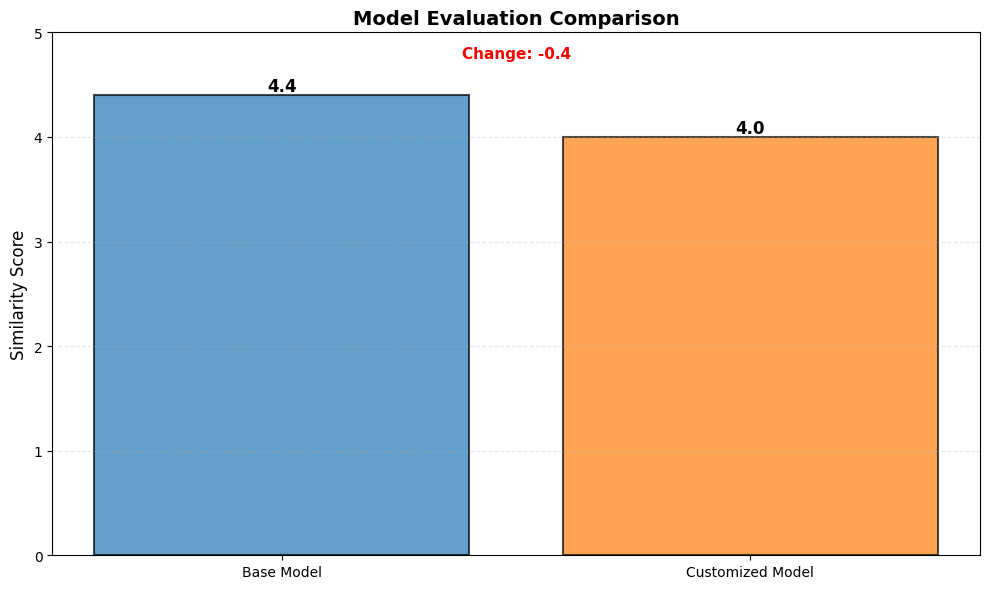


EVALUATION SUMMARY
Base Model Score:       4.4
Customized Model Score: 4.0
Change:                 -0.4


In [ ]:
# Step 2.8: Fetch and plot evaluation results
import requests
import pandas as pd
import matplotlib.pyplot as plt

# Get job details (update job_id with your actual job ID)
# job_id = "69211247d4961017a0216202"  # Replace with your job ID
API_BASE_URL = "http://localhost:8000"

# Get job details
response = requests.get(f"{API_BASE_URL}/api/jobs/{job_id}")
job_data = response.json()

# Extract evaluation scores
evaluations = []
for nim in job_data.get('nims', []):
    model_name = nim['model_name']
    for eval_result in nim.get('evaluations', []):
        evaluations.append({
            'model': model_name,
            'eval_type': eval_result['eval_type'],
            'similarity': eval_result['scores'].get('similarity', 0),
            'runtime_seconds': eval_result['runtime_seconds']
        })

# Create DataFrame
df = pd.DataFrame(evaluations)
print("Evaluation Results:")
print(df)

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))

if not df.empty:
    # Group by eval_type
    base_score = df[df['eval_type'] == 'base-eval']['similarity'].values[0] if len(df[df['eval_type'] == 'base-eval']) > 0 else 0
    custom_score = df[df['eval_type'] == 'customized-eval']['similarity'].values[0] if len(df[df['eval_type'] == 'customized-eval']) > 0 else 0
    
    # Create bar plot
    models = ['Base Model', 'Customized Model']
    scores = [base_score, custom_score]
    colors = ['#1f77b4', '#ff7f0e']
    
    bars = ax.bar(models, scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Add value labels on bars
    for bar, score in zip(bars, scores):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{score:.1f}',
                ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_ylabel('Similarity Score', fontsize=12)
    ax.set_title('Model Evaluation Comparison', fontsize=14, fontweight='bold')
    ax.set_ylim(0, 5)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add interpretation
    improvement = custom_score - base_score
    color = 'green' if improvement >= 0 else 'red'
    plt.text(0.5, 0.95, f'Change: {improvement:+.1f}', 
             transform=ax.transAxes, ha='center', 
             fontsize=11, color=color, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\n{'='*60}")
    print("EVALUATION SUMMARY")
    print(f"{'='*60}")
    print(f"Base Model Score:       {base_score:.1f}")
    print(f"Customized Model Score: {custom_score:.1f}")
    print(f"Change:                 {improvement:+.1f}")
    print(f"{'='*60}")
else:
    print("No evaluation data found!")

In [ ]:
# Optional: Download and inspect evaluation dataset from NeMo Data Store
import requests
import json

DATASTORE_URL = "http://data-store.test"
NAMESPACE = "dfwbp"
DATASET_NAME = "flywheel-eval-primary_assistant-1763082932"  # Update with your dataset name

data_url = f"{DATASTORE_URL}/v1/hf/datasets/{NAMESPACE}/{DATASET_NAME}/resolve/main/eval_data.jsonl"
print(f"Downloading from: {data_url}")

response = requests.get(data_url)
if response.status_code == 200:
    print("✓ Downloaded successfully!")
    eval_samples = [json.loads(line) for line in response.text.strip().split('\n') if line.strip()]
    print(f"\nLoaded {len(eval_samples)} samples")
    print(f"\nFirst sample preview:\n{json.dumps(eval_samples[0], indent=2)[:500]}...")

✓ Downloaded successfully!

Loaded 100 samples
{
  "request": {
    "model": "meta/llama-3.3-70b-instruct",
    "messages": [
      {
        "role": "system",
        "content": "You are a helpful customer support assistant for NVIDIA Gear Store. \nYour primary role is to assist the user to answer customer queries. \nIf a customer asks about his products, his order status, or queries related to processing return, \ndelegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself. \nOnly the specialized assistants are given permission to do this for the user.\nProvide detailed information to the customer, and always double-check the database before concluding that information is unavailable. \nThe user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. \nWhen searching, be persistent. Expand your query bounds if the first search

In [ ]:
# Optional: Verify data structure has proper tool_calls format
import json

def check_tool_calls_format(file_path, max_samples=5):
    """Check if data samples have the expected tool_calls structure."""
    with open(file_path, 'r') as f:
        for i, line in enumerate(f):
            if i >= max_samples:
                break
            record = json.loads(line)
            msg = record['response']['choices'][0]['message']
            has_tool_calls = 'tool_calls' in msg
            has_content = 'content' in msg
            print(f"Sample {i+1}: tool_calls={has_tool_calls}, content={has_content}")

# Uncomment to run check:
# check_tool_calls_format(data_dir / "filtered_high_quality_samples_aiva1.jsonl")

Sample 1:
  Has 'tool_calls': False
  Has 'content': True
  Content: {"name": "ToReturnProcessing", "description": "handles inquiries regarding retur...

Sample 2:
  Has 'tool_calls': False
  Has 'content': True
  Content: {"name": "ToOrderStatusAssistant", "parameters": {"query": "mug delivery issue",...

Sample 3:
  Has 'tool_calls': False
  Has 'content': True
  Content: <ToOrderStatusAssistant query="Check the status of my NVIDIA 4080 order for next...

Sample 4:
  Has 'tool_calls': False
  Has 'content': True
  Content: {"name": "ToProductQAAssistant", "parameters": {"query": "Computer Care Kit cont...



This shows that evaluation was generic and not tool_calling based which is a problem. Modifying system prompt to ensure correct output format and re-running pipeline